Peakhours includes a filtered version of data from 8am to 8pm on Monday through Friday. Notably it was used on the simulation data to represent the highest stress on Austin data. It includes header columns: array(['', 'IncidentForeignKey', 'Radio_Name', 'Longitude_At_Assign_Time',
       'Latitude_At_Assign_Time', 'Time_Assigned', 'Time_Enroute',
       'Time_ArrivedAtScene', 'Time_Depart_Scene',
       'Time_Arrive_Destination', 'Time_Available', 'Time_Call_Cleared',
       'Call_Disposition', 'Longitude_Of_Emergency',
       'Latitude_Of_Emergency', 'transport_time', 'grid_time'],
      dtype='<U30')
Which I will convert to [IncidentForeignKey, FIPS, call2station] 

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#for grid
import json
import math
import collections
#for geographic data preprocessing
import geopandas as gpd
from shapely import geometry


In [18]:
peakhours_df = pd.read_csv("../Output_Data/peakhours.csv")
socioeconomic_df = pd.DataFrame()

In [6]:
peakhours_df.head()

,Unnamed: 0,IncidentForeignKey,Radio_Name,Longitude_At_Assign_Time,Latitude_At_Assign_Time,Time_Assigned,Time_Enroute,Time_ArrivedAtScene,Time_Depart_Scene,Time_Arrive_Destination,Time_Available,Time_Call_Cleared,Call_Disposition,Longitude_Of_Emergency,Latitude_Of_Emergency,transport_time,grid_time
0,1,23397873,M09,-97.972866,30.333385,2019-01-01 19:43:36.000,2019-01-01 19:45:27.030,2019-01-01 19:48:39.770,2019-01-01 20:19:00.870,2019-01-01 20:24:43.093,2019-01-01 20:51:12.877,2019-01-01 20:51:12.877,Baylor Scott & White - Lakeway,-97.961,30.325,192,321.275070
1,3,23408585,DM03,-97.751235,30.246114,2019-01-03 14:20:41.000,2019-01-03 14:20:54.110,2019-01-03 14:27:27.613,NaN,NaN,2019-01-03 14:35:14.657,2019-01-03 14:35:14.657,False Alarm Call,-97.777,30.251,393,344.477564
2,4,23408585,DMO02,-97.751966,30.245411,2019-01-03 14:20:58.117,2019-01-03 14:20:58.140,2019-01-03 14:26:59.083,NaN,NaN,2019-01-03 14:34:24.343,2019-01-03 14:34:24.343,Dual w/ other ATCEMS Unit,-97.777,30.251,360,344.477564
3,8,23439455,M10,-97.742590,30.418169,2019-01-07 17:28:48.000,2019-01-07 17:30:12.067,2019-01-07 17:47:53.030,NaN,NaN,2019-01-07 17:56:40.097,2019-01-07 17:56:40.097,False Alarm Call,-97.747,30.407,1060,354.783231
4,10,23444785,M04,-97.725892,30.290517,2019-01-08 13:55:38.000,2019-01-08 13:55:55.987,2019-01-08 14:04:26.413,2019-01-08 14:20:11.810,2019-01-08 14:41:12.577,2019-01-08 15:09:21.000,2019-01-08 15:09:21.000,Saint Davids Med Ctr,-97.626,30.294,510,408.916370


In [29]:
IncidentForeignKey = peakhours_df.IncidentForeignKey
transport_time = peakhours_df.transport_time
grid_time = peakhours_df.grid_time
lon_list = peakhours_df.Longitude_At_Assign_Time
lat_list = peakhours_df.Latitude_At_Assign_Time

In [24]:
socioeconomic_df['IncidentForeignKey'] = IncidentForeignKey
socioeconomic_df['call2station'] = transport_time
socioeconomic_df.head(2)

,IncidentForeignKey,call2station
0,23397873,192
1,23408585,393


(array([1414.,  195.,  177.,  169.,  261.,  259.,  389.,  425.,  525.,
         706.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

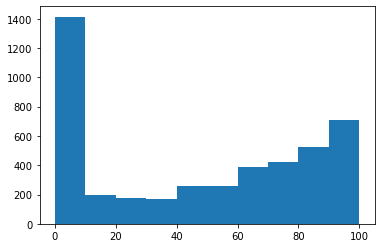

In [17]:
#sanity check that reported travel time looks correct
plt.hist(transport_time, range=(0, 100))

### finally do the fips column

In [31]:
#load grid 
# This is the grid object, which is used throughout all data preprocessing.
# It represents the city of Austin through a series of grids.
# It thus makes a tractable way to compute distance between grids, ect. 
class Grid():
    def __init__(self, grid_json):
        self.grid = grid_json
        self.min_lat = self.grid["latitude_min"]
        self.min_lon = self.grid["longitude_min"]
        self.max_lat = self.grid["latitude_max"]
        self.max_lon = self.grid["longitude_max"]
        self.latitude_delta = self.grid["latitude_step"]
        self.longitude_delta = self.grid["longitude_step"]
        self.nrows = math.ceil((self.max_lat - self.min_lat) / self.latitude_delta)
        self.ncols = math.ceil((self.max_lon - self.min_lon) / self.longitude_delta)
        self.times = self.grid["time_matrix"]
        self.census_tract_region_map = self.grid["census_tract_region_mapping"]
        self.region_to_tract = collections.defaultdict(list)
        for census_tract in self.census_tract_region_map:
            for region in self.census_tract_region_map[census_tract]:
                self.region_to_tract[region].append(census_tract)
    def map_point_to_region(self, latitude, longitude):
        return math.floor((latitude-self.min_lat)/self.latitude_delta) * self.ncols  + math.floor((longitude-self.min_lon)/self.longitude_delta)
    def get_representative(self, region_num):
        row_num = region_num//self.ncols
        col_num = region_num - row_num*self.ncols
        lat = self.min_lat + row_num * self.latitude_delta + 0.5*self.latitude_delta
        lon = self.min_lon + col_num * self.longitude_delta + 0.5*self.longitude_delta
        return [lon, lat]
    def get_time(self, region1, region2):
        try:
            return self.times[region1][region2]
        except IndexError:
            return -1
    def region_to_census_tract(self, region):
        try:
            return self.region_to_tract[region]
        except KeyError:
            return "0_0"

In [39]:
# Using smaller distance matrix for hopefully faster runtime of Julia code
with open("../Input_Data/grid_info_3660.json", "r") as f:
    grid_json = json.load(f)
g = Grid(grid_json)

In [38]:
#load shape data
shapefile = gpd.read_file("../Input_Data/xinyu_shape_file/Travis_tracts.shp")
#print(shapefile)

In [67]:
fips_list = []
out_of_bound_count = 0
no_fips_count = 0
for i in range(0,len(lon_list)):
    lon = lon_list[i]
    lat = lat_list[i]
    if(lon < g.min_lon) or (lon > g.max_lon):
            out_of_bound_count = out_of_bound_count + 1
            fips_list.append(-1)
            continue
    elif(lat < g.min_lat) or (lat >g.max_lat):
            out_of_bound_count = out_of_bound_count + 1
            fips_list.append(-1)
            continue
    point = geometry.Point(lon, lat)
    in_fip = 0 #bool mask
    for j in range(len(shapefile["geometry"])):
        if(shapefile["geometry"][j].contains(point)):
            fips_list.append(shapefile["FIPS"][j])
            in_fip = 1
            continue
    if(not in_fip):
        no_fips_count = no_fips_count + 1
        fips_list.append(-1)
    if(i % 1000 == 0):
        print(i)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000


In [68]:
len(fips_list)

103954

In [55]:
socioeconomic_df["FIPS"] = fips_list

ValueError: Length of values (99390) does not match length of index (103954)

In [57]:
len(fips_list)

99390

In [ ]:
socioeconomic_df.to_csv('socioeconomic_df.csv', index=False)